In [21]:
#This notebook is me trying to reimplement dm electron scattering rate calculation found in wimprates
#https://github.com/JelleAalbers/wimprates/tree/master

In [2]:
import numpy as np
import numericalunits as nu
from scipy.stats import binom
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from utils import load_pickle
shell_data = load_pickle('dme/dme_ionization_ff.pkl')
for _shell, _sd in shell_data.items():
    print(_sd.keys())

dict_keys(['lnks', 'lnqs', 'ffsquared'])
dict_keys(['lnks', 'lnqs', 'ffsquared'])
dict_keys(['lnks', 'lnqs', 'ffsquared'])
dict_keys(['lnks', 'lnqs', 'ffsquared'])
dict_keys(['lnks', 'lnqs', 'ffsquared'])
dict_keys(['lnks', 'lnqs', 'ffsquared'])
dict_keys(['lnks', 'lnqs', 'ffsquared'])


In [9]:
# import pickle
# from scipy.integrate import quad, dblquad

# from scipy.interpolate import RegularGridInterpolator, interp1d



# dme_shells = [(5, 1), (5, 0), (4, 2), (4, 1), (4, 0)]
# l_to_number = dict(s=0, p=1, d=2, f=3)
# l_to_letter = {v: k for k, v in l_to_number.items()}

# def load_pickle(path):
#     with open(path, mode='rb') as f:
#         return pickle.load(f)
# shell_data = load_pickle('./dme_ionization_ff.pkl')
# def shell_str(n, l):
#     if isinstance(l, str):
#         return str(n) + l
#     return str(n) + l_to_letter[l]

# def dme_ionization_ff(shell, e_er, q):
#     """Return dark matter electron scattering ionization form factor

#     Outside the parametrized range, the form factor is assumed 0
#     to give conservative results.

#     :param shell: Name of atomic shell, e.g. '4p'
#         Note not all shells are included in the data.
#     :param e_er: Electronic recoil energy
#     :param q: Momentun transfer
#     """
#     if isinstance(shell, tuple):
#         shell = shell_str(*shell)

#     lnq = np.log(q / (nu.me * nu.c0 * nu.alphaFS))
#     # From Mathematica: (*ER*) (2 lnkvalues[[j]])/Log[10]
#     # log10 (E/Ry) = 2 lnk / ln10
#     # lnk = log10(E/Ry) * ln10 / 2
#     #     = lng(E/Ry) / 2
#     # Ry = rydberg = 13.6 eV
#     ry = nu.me * nu.e ** 4 / (8 * nu.eps0 ** 2 * nu.hPlanck ** 2)
#     lnk = np.log(e_er / ry) / 2
#     print('lnk',lnk)
#     print('lnq',lnq)
#     result = 10**(shell_data[shell]['log10ffsquared_itp'](
#         np.vstack([lnk, lnq]).T))
#     print(result)
#     return result

# def binding_es_for_dme(n, l):
#     """Return binding energy of Xenon's (n, l) orbital
#     according to Essig et al. 2017 Table II

#     Note these are different from e.g. Ibe et al. 2017!
#     """

#     return {'4s': 213.8,
#             '4p': 163.5,
#             '4d': 75.6,
#             '5s': 25.7,
#             '5p': 12.4}[shell_str(n, l)] * nu.eV
# def v_min_dme(eb, erec, q, mw):
#     """Minimal DM velocity for DM-electron scattering
#     :param eb: binding energy of shell
#     :param erec: electronic recoil energy energy
#     :param q: momentum transfer
#     :param mw: DM mass
#     """
#     return (erec + eb) / q + q / (2 * mw)

# _HALO_DEFAULTS = dict(
#     rho_dm = 0.3, # GeV / c2 / cm3
#     v_esc = 544,  # km/s
#     v_orbit = 29.8,  # km/s
#     v_pec = (11.1, 12.2, 7.3),  # km/s
#     v_0 = 238,  # km/s
# )
# def j2000_from_ymd(year, month, day_of_month):
#     """"Returns the fractional number of days since J2000.0 epoch.
#     :param year: Year
#     :param month: Month (January = 1)
#     :param day: Day of month (starting from 1), fractional days are
#     relative to midnight UT.
#     """
#     assert month > 0
#     assert month < 13

#     y = year if month > 2 else year - 1
#     m = month if month > 2 else month + 12

#     return (np.floor(365.25 * y)
#             + np.floor(30.61 * (m + 1))
#             + day_of_month - 730563.5)

# def earth_velocity(t, v_0 = None):
#     """Returns 3d velocity of earth, in the galactic rest frame,
#     in galactic coordinates.
#     :param t: J2000.0 timestamp
#     :param v_0: Local standard of rest velocity

#     Values and formula from https://arxiv.org/abs/1209.3339
#     Assumes earth circular orbit.
#     """
#     if v_0 is None :
#         v_0 = _HALO_DEFAULTS['v_0'] * nu.km/nu.s

#     # e_1 and e_2 are the directions of earth's velocity at t1
#     # and t1 + 0.25 year.
#     e_1 = np.array([0.9931, 0.1170, -0.01032])
#     e_2 = np.array([-0.0670, 0.4927, -0.8676])
#     # t1 is the time of the vernal equinox, March 21. Does it matter what
#     # year? Precession of equinox takes 25800 years so small effect.
#     t1 = j2000_from_ymd(2000, 3, 21)
#     # Angular frequency
#     omega = 2 * np.pi / 365.25
#     phi = omega * (t - t1)

#     # Mean orbital velocity of the Earth (Lewin & Smith appendix B)
#     v_orbit = _HALO_DEFAULTS['v_orbit'] * nu.km / nu.s

#     v_earth_sun = v_orbit * (e_1 * np.cos(phi) + e_2 * np.sin(phi))

#     # Velocity of Local Standard of Rest
#     v_lsr = np.array([0, v_0, 0])
#     # Solar peculiar velocity
#     v_pec = np.array(_HALO_DEFAULTS['v_pec']) * nu.km/nu.s

#     return v_lsr + v_pec + v_earth_sun


# def v_earth(t=None, v_0=None):
#     """Return speed of earth relative to galactic rest frame
#     Velocity of earth/sun relative to gal. center (eccentric orbit, so not
#     equal to v_0).

#     :param t: J2000 timestamp or None
#     :param v_0: Local standard of rest velocity
#     """
#     if t is None:
#         # This day (Feb 29 2000) gives ~ the annual average speed
#         t = 59.37
#     return np.sum(earth_velocity(t, v_0=v_0) ** 2) ** 0.5



# def v_max(t=None, v_esc=None, v_0=None):
#     """Return maximum observable dark matter velocity on Earth."""
#     # defaults
#     v_esc = _HALO_DEFAULTS['v_esc'] * nu.km/nu.s if v_esc is None else v_esc
#     v_0 = _HALO_DEFAULTS['v_0'] * nu.km / nu.s if v_0 is None else v_0
#     # args do not change value when you do a
#     # reset_unit so this is necessary to avoid errors
#     if t is None:
#         return v_esc + v_earth(t, v_0=v_0)
#     else:
#         return v_esc + np.sum(earth_velocity(t, v_0=v_0) ** 2) ** 0.5

# def observed_speed_dist(v, t=None, v_0=None, v_esc=None):
#     from scipy.special import erf

#     """Observed distribution of dark matter particle speeds on earth
#     under the standard halo model.

#     See my thesis for derivation ;-)
#     If you find a paper where this formula is written out explicitly, please
#     let me know. I spent a lot of time looking for this in vain.

#     Optionally supply J2000.0 time t to take into account Earth's orbital
#     velocity.

#     Further inputs: scale velocity v_0 and escape velocity v_esc_value
#     """
#     v_0 = _HALO_DEFAULTS['v_0'] * nu.km/nu.s if v_0 is None else v_0
#     v_esc = _HALO_DEFAULTS['v_esc'] * nu.km/nu.s if v_esc is None else v_esc
#     v_earth_t = v_earth(t, v_0=v_0)

#     # Normalization constant, see Lewin&Smith appendix 1a
#     _w = v_esc/v_0
#     k = erf(_w) - 2/np.pi**0.5 * _w * np.exp(-_w**2)  # unitless

#     # Maximum cos(angle) for this velocity, otherwise v0
#     xmax = np.minimum(1,
#                       (v_esc**2 - v_earth_t**2 - v**2)
#                       / (2 * v_earth_t * v))
#     # unitless

#     y = (k * v / (np.pi**0.5 * v_0 * v_earth_t)
#          * (np.exp(-((v-v_earth_t)/v_0)**2)
#          - np.exp(-1/v_0**2 * (v**2 + v_earth_t**2
#                   + 2 * v * v_earth_t * xmax))))
#     # units / (velocity)

#     # Zero if v > v_max
#     try:
#         len(v)
#     except TypeError:
#         # Scalar argument
#         if v > v_max(t, v_esc, v_0=v_0):
#             return 0
#         else:
#             return y
#     else:
#         # Array argument
#         y[v > v_max(t, v_esc, v_0=v_0)] = 0
#         return y
    

# class StandardHaloModel:
#     """
#         class used to pass a halo model to the rate computation
#         must contain:
#         :param v_esc -- escape velocity
#         :function velocity_dist -- function taking v,t
#         giving normalised velocity distribution in earth rest-frame.
#         :param rho_dm -- density in mass/volume of dark matter at the Earth
#         The standard halo model also allows variation of v_0
#         :param v_0: Local standard of rest velocity
#     """

#     def __init__(self, v_0=None, v_esc=None, rho_dm=None):
#         self.v_0 = _HALO_DEFAULTS['v_0'] * nu.km/nu.s if v_0 is None else v_0
#         self.v_esc = _HALO_DEFAULTS['v_esc'] * nu.km/nu.s if v_esc is None else v_esc
#         self.rho_dm = _HALO_DEFAULTS['rho_dm'] * nu.GeV/nu.c0**2 / nu.cm**3 if rho_dm is None else rho_dm

#     def velocity_dist(self, v, t):
#         # in units of per velocity,
#         # v is in units of velocity
#         return observed_speed_dist(v, t, v_0=self.v_0, v_esc=self.v_esc)

# def velocity_integral_without_time(halo_model=None):
#     halo_model = StandardHaloModel() if halo_model is None else halo_model
#     _v_mins = np.linspace(0, 1, 1000) * v_max(None, halo_model.v_esc)
#     _ims = np.array([
#         quad(lambda v: 1 / v * halo_model.velocity_dist(v,None),
#             _v_min,
#             v_max(None, halo_model.v_esc ))[0]
#         for _v_min in _v_mins])
    
#     # Store interpolator in km/s rather than unit-dependent numbers
#     # so we don't have to recalculate them when nu.reset_units() is called
#     inverse_mean_speed_kms = interp1d(
#         _v_mins / (nu.km/nu.s),
#         _ims * (nu.km/nu.s),
#         # If we don't have 0 < v_min < v_max, we want to return 0
#         # so the integrand vanishes
#         fill_value=0, bounds_error=False)
#     return inverse_mean_speed_kms

# inverse_mean_speed_kms = velocity_integral_without_time()

# ATOMIC_WEIGHT = dict(
#     Xe=131.293,
#     Ar=39.948,
#     Ge=72.64,
#     Si=28.0855
# )
# def mn(material='Xe'):
#     """Mass of nucleus (not nucleon!)"""
#     return ATOMIC_WEIGHT[material] * nu.amu


# def rate_dme(erec, n, l, mw, sigma_dme,
#              f_dm='1',
#              t=None, halo_model = None, **kwargs):
#     """Return differential rate of dark matter electron scattering vs energy
#     (i.e. dr/dE, not dr/dlogE)
#     :param erec: Electronic recoil energy
#     :param n: Principal quantum numbers of the shell that is hit
#     :param l: Angular momentum quantum number of the shell that is hit
#     :param mw: DM mass
#     :param sigma_dme: DM-free electron scattering cross-section at fixed
#     momentum transfer q=0
#     :param f_dm: One of the following:
#      '1':     |F_DM|^2 = 1, contact interaction / heavy mediator (default)
#      '1_q':   |F_DM|^2 = (\alpha m_e c / q), dipole moment
#      '1_q2': |F_DM|^2 = (\alpha m_e c / q)^2, ultralight mediator
#     :param t: A J2000.0 timestamp.
#     If not given, a conservative velocity distribution is used.
#     :param halo_model: class (default to standard halo model) containing velocity distribution
#     """
#     halo_model = StandardHaloModel() if halo_model is None else halo_model
#     shell = shell_str(n, l)
#     eb = binding_es_for_dme(n, l)

#     f_dm = {
#         '1': lambda q: 1,
#         '1_q': lambda q: nu.alphaFS * nu.me * nu.c0 / q,
#         '1_q2': lambda q: (nu.alphaFS * nu.me * nu.c0 / q)**2
#     }[f_dm]

#     # No bounds are given for the q integral
#     # but the form factors are only specified in a limited range of q
#     qmax = (np.exp(shell_data[shell]['lnqs'].max())
#             * (nu.me * nu.c0 * nu.alphaFS))

#     if t is None:
#         # Use precomputed inverse mean speed,
#         # so we only have to do a single integral
#         def diff_xsec(q):
#             vmin = v_min_dme(eb, erec, q, mw)
#             result = q * dme_ionization_ff(shell, erec, q) * f_dm(q)**2
#             # Note the interpolator is in kms, not unit-carrying numbers
#             # see above
#             result *= inverse_mean_speed_kms(vmin / (nu.km/nu.s))
#             result /= (nu.km/nu.s)
#             return result
        
#         r = quad(diff_xsec, 0, qmax)[0]

#     else:
#         # Have to do double integral
#         # Note dblquad expects the function to be f(y, x), not f(x, y)...
#         def diff_xsec(v, q):
#             result = q * dme_ionization_ff(shell, erec, q) * f_dm(q)**2
#             result *= 1 / v * halo_model.velocity_dist(v, t)
#             return result

#         r = dblquad(
#             diff_xsec,
#             0,
#             qmax,
#             lambda q: v_min_dme(eb, erec, q, mw),
#             lambda _: v_max(t, halo_model.v_esc),
#             **kwargs)[0]

#     mu_e = mw * nu.me / (mw + nu.me)

#     return (
#         # Convert cross-section to rate, as usual
#         halo_model.rho_dm / mw * (1 / mn())
#         # d/lnE -> d/E
#         * 1 / erec
#         # Prefactors in cross-section
#         * sigma_dme / (8 * mu_e ** 2)
#         * r)
# for _shell, _sd in shell_data.items():
#     _sd['log10ffsquared_itp'] = RegularGridInterpolator(
#         (_sd['lnks'], _sd['lnqs']),
#         np.log10(_sd['ffsquared']),
#         bounds_error=False, fill_value=-float('inf'),)


<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/k8/_jhxw6sx2gj8wjzbhc789q540000gn/T/ipykernel_75847/1755053272.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(extend='both', label='$|f_\mathrm{ion}|^2$')
/var/folders/k8/_jhxw6sx2gj8wjzbhc789q540000gn/T/ipykernel_75847/1755053272.py:22: SyntaxWarning: invalid escape sequence '\s'
  "$q = \sqrt{2 m_e \, (E_R + E_b)}$", color='w')


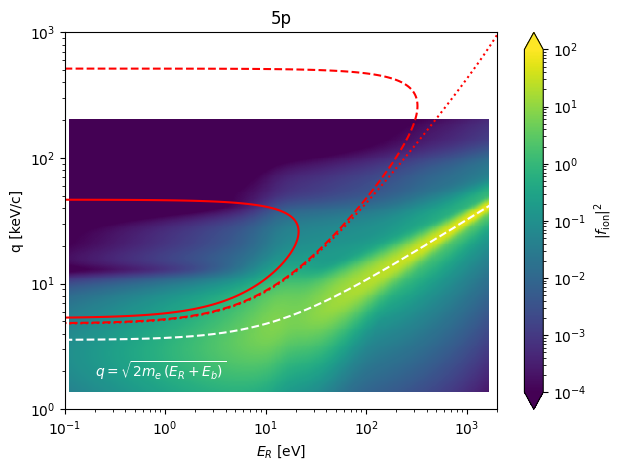

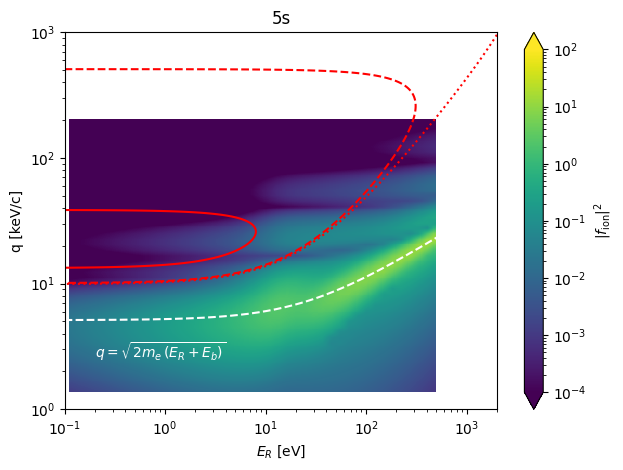

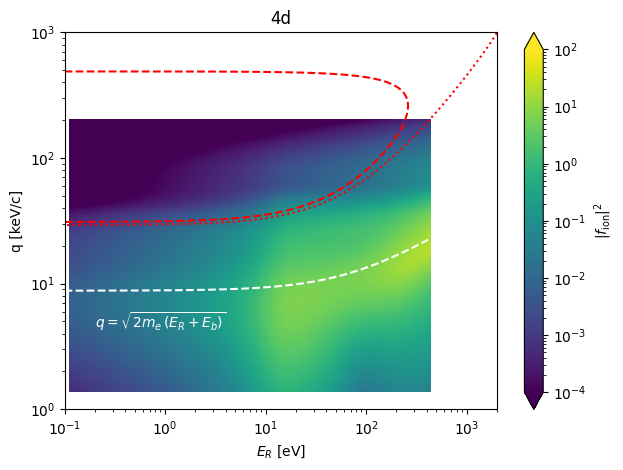

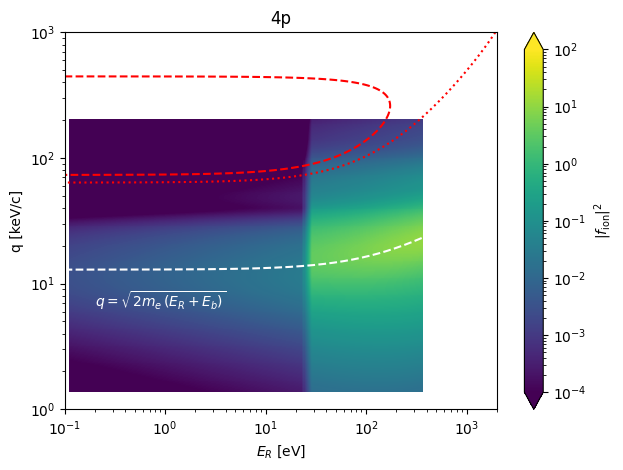

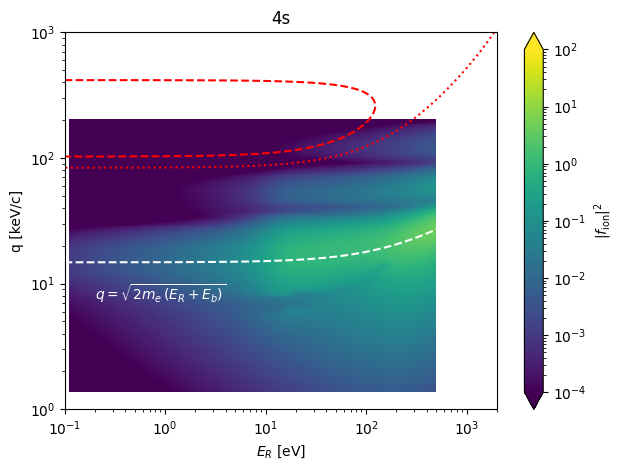

In [4]:
from electron import dme_shells,dme_ionization_ff,binding_es_for_dme,shell_str,v_min_dme,v_max,rate_dme
e_er = np.geomspace(.1, 2000, 400)
q = np.geomspace(1, 1000, 400)
grid_e, grid_q = np.meshgrid(e_er, q)

for shell in dme_shells:
    ff2 = dme_ionization_ff(
        shell,
        grid_e.ravel() * nu.eV,
        grid_q.ravel() * nu.keV / nu.c0).reshape(grid_e.shape)

    plt.pcolormesh(grid_e, grid_q, ff2, 
                   norm=matplotlib.colors.LogNorm(vmin=1e-4, vmax=1e2),
                   cmap=plt.cm.viridis)
    plt.colorbar(extend='both', label='$|f_\mathrm{ion}|^2$')
    
    eb = binding_es_for_dme(*shell)
    y = (2 * nu.me * (e_er * nu.eV + eb))**0.5 / (nu.keV/nu.c0)
    plt.plot(e_er, y,
             color='w', linestyle='--')
    plt.text(0.2, 0.5 * y[np.argmin(np.abs(e_er - 0.2))],
             "$q = \sqrt{2 m_e \, (E_R + E_b)}$", color='w')
    
    for m, linestyle in zip([10, 100, 1000], ['-', '--', ':']):
        plt.contour(
            grid_e, grid_q, 
            v_min_dme(eb, grid_e * nu.eV, grid_q * nu.keV/nu.c0, 
                         mw=m * nu.MeV/nu.c0**2),
            levels=[v_max()], colors=['r'], linestyles=[linestyle])

    plt.xscale('log')
    plt.xlabel("$E_R$ [eV]")

    plt.yscale('log')
    plt.ylim(1, 1000)
    plt.ylabel("q [keV/c]")

    shell = shell_str(*shell)
    plt.title(shell)
    plt.tight_layout()
    plt.savefig('form_factor_%s.png' % shell, dpi=200, bbox_inches='tight')
    plt.show()

In [5]:

additional_quanta = {
    '4s': 3,
    '4p': 6,
    '4d': 4,
    '5s': 0,
    '5p': 0
}


def rates_to_ne(e_er, drs,
                W=None, max_n_el=16,
                p_primary=1, p_secondary=0.83,
                swap_4s4p=False):
    """Return (n_electrons, {shell: rate / (kg day) for each electron count})
    
    :param W: Work function (energy need to produce a quantum)
    :param max_n_el: Maximum number of electrons to consider.
    :param p_primary: Probability that primary electron survives
    :param p_secondary: Probability that secondary quanta survive as electrons
    :param swap_4s4p: If True, swap differential rates of 4s and 4p
    """
    if W is None:
        W = 13.8 * nu.eV
        
    n_el = np.arange(max_n_el + 1, dtype=int)
    result = dict()    
    
    # We need an "energy bin size" to multiply with (or do some fancy integration)
    # I'll use the differences between the points at which the differential 
    # rates were computed.
    # To ensure this doesn't give a bias, nearby bins can't differ too much 
    # (e.g. use a linspace or a high-n logspace/geomspace)
    binsizes = np.array(np.diff(e_er).tolist() + [e_er[-1] - e_er[-2]])
    
    for shell, rates in drs.items():
        if swap_4s4p:
            # Somehow we can reproduce 1703.00910
            # if we swap 4s <-> 4p here??
            if shell == '4s':
                rates = drs['4p']
            elif shell == '4p':
                rates = drs['4s']

        # Convert to from energy to n_electrons
        r_n = np.zeros(len(n_el))
        for e, r in zip(e_er, rates * binsizes):
            n_secondary = int(np.floor(e / W)) + additional_quanta[shell]
            r_n += r * (
                p_primary * binom.pmf(n_el - 1, n=n_secondary, p=p_secondary)
                + (1 - p_primary) * binom.pmf(n_el, n=n_secondary, p=p_secondary))

        # We can't see "0-electron events"
        # Set their rate to 0 so we don't sum them accidentally
        r_n[0] = 0
        
        result[shell] = r_n
        
    return n_el, result

<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
/var/folders/k8/_jhxw6sx2gj8wjzbhc789q540000gn/T/ipykernel_78172/582911467.py:23: SyntaxWarning: invalid escape sequence '\c'
  title = "$m_\chi = %s$ $\mathrm{GeV}/c^2$, $\sigma =$ %s $\mathrm{cm}^2$, $F_\mathrm{DM} = 1$" % (m_gev, s_cm2)


array([1.23595555e+06, 1.22475217e+06, 1.21327284e+06, 1.20212918e+06,
       1.19077770e+06, 1.17917007e+06, 1.16800921e+06, 1.15666122e+06,
       1.14573956e+06, 1.13489928e+06, 1.12394847e+06, 1.11394829e+06,
       1.10387354e+06, 1.09442271e+06, 1.08559276e+06, 1.07686248e+06,
       1.06956295e+06, 1.06238745e+06, 1.05630930e+06, 1.05130534e+06,
       1.04637223e+06, 1.04410499e+06, 1.04217676e+06, 1.04183086e+06,
       1.04361568e+06, 8.84581960e+05, 1.05214642e+06, 1.05971682e+06,
       1.06997405e+06, 1.08458039e+06, 1.09994326e+06, 1.12259420e+06,
       1.14816941e+06, 1.17869267e+06, 1.21773454e+06, 1.26006493e+06,
       1.31246461e+06, 1.36828570e+06, 1.42849354e+06, 1.48682075e+06,
       1.54175956e+06, 1.58054109e+06, 1.59987158e+06, 1.59990046e+06,
       1.56125653e+06, 1.50684182e+06, 1.42323159e+06, 1.32629400e+06,
       1.22140030e+06, 1.10789708e+06, 9.97774299e+05, 8.89639202e+05,
       7.87503427e+05, 6.92844585e+05, 6.05444345e+05, 5.26861178e+05,
      

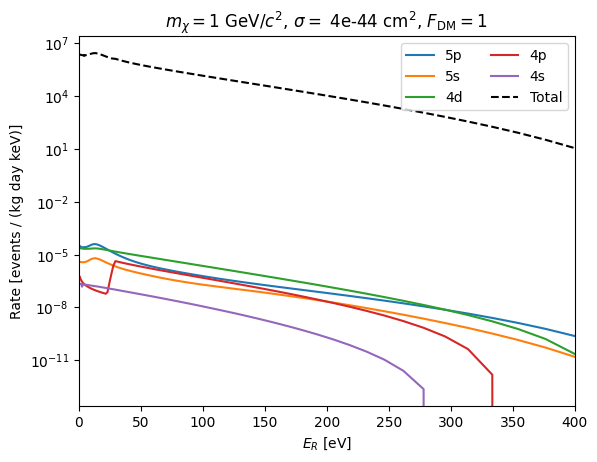

In [1]:
from electron import *
import numpy as np
import matplotlib.pyplot as plt
import numericalunits as nu
e_er = np.geomspace(1, 400, 100)
m_gev = 1
s_cm2 = 4e-44
drs = dict()
for n, l in dme_shells:
    
    drs[shell_str(n,l)] = dr = rate_dme(
        e_er * nu.eV, 
        n, l, 
        mw=m_gev * nu.GeV/nu.c0**2, 
        sigma_dme=s_cm2 * nu.cm**2)
    
    plt.plot(e_er, dr * (nu.kg * nu.keV * nu.day),
             label=shell_str(n, l))
plt.plot(e_er, np.sum(list(drs.values()), axis=0),
         label='Total', c='k', linestyle='--')


title = "$m_\chi = %s$ $\mathrm{GeV}/c^2$, $\sigma =$ %s $\mathrm{cm}^2$, $F_\mathrm{DM} = 1$" % (m_gev, s_cm2)
plt.title(title)
plt.legend(loc='upper right', ncol=2)

plt.xlabel("$E_R$ [eV]")
plt.xlim(0, 400)

plt.yscale('log')
plt.ylabel("Rate [events / (kg day keV)]")
drs['5p']

# plt.ylim(1e-10, 1e-4)

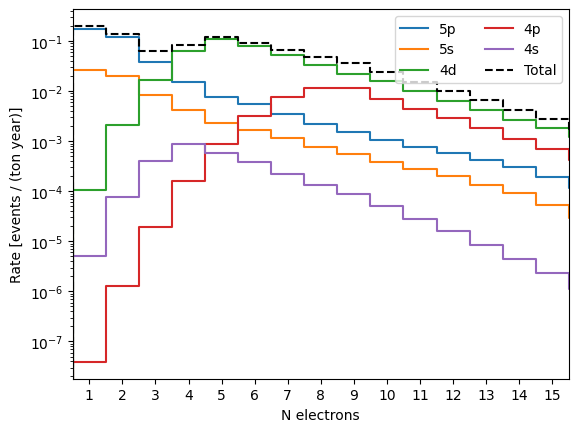

In [18]:
n_el, drsn = rates_to_ne(e_er * nu.eV, drs, 
                             swap_4s4p=False)
for shell, rn in drsn.items():
        rn *= (1000 * nu.kg * nu.year)
        plt.plot(n_el, rn, drawstyle='steps-mid', label=shell)
plt.plot(n_el, np.sum(list(drsn.values()), axis=0),
            label='Total',
            drawstyle='steps-mid', 
            linestyle='--', 
            c='k')

#     title = "$m_\chi = %s$ $\mathrm{GeV}/c^2$, $\sigma_p =$ %s $\mathrm{cm}^2$, $F_\mathrm{DM} = 1$" % (m_gev, s_cm2)

#     plt.title(title)# + (' -- SWAP 4s<->4p' if True else ''))
plt.legend(loc='upper right', ncol=2)

plt.xticks(np.arange(1, 16))
plt.xlim(0.5, 15.5)
plt.xlabel("N electrons")

plt.yscale('log')
# plt.ylim(1e-5, .45)
plt.ylabel("Rate [events / (ton year)]")

plt.show()
plt.close()